In [39]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt
from IPython import display

# import seqlogo
# from IPython.display import clear_output
# import datetime
# from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

True

In [40]:
use_kmers = False
N0 = 100
N1 = 2
N2 = 16
Nc = 8

lr = 0.01

In [41]:
def get_data(ensid):
    x = torch.randn(len(ensid),N0)
    y = np.zeros((len(ensid),Nc))
    y += np.arange(Nc)+0.251
    
    y = torch.tensor(y, dtype=torch.float)
    
    return {'x': x, 'y': y}

In [42]:
get_data(['asdf'])['y']

tensor([[0.2510, 1.2510, 2.2510, 3.2510, 4.2510, 5.2510, 6.2510, 7.2510]])

In [35]:
# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc4 = nn.Linear(N0, Nc);
        
    def forward(self, x): 
        x = self.fc4(x) # Out: N x C        
        
        return x

In [36]:
net = Net()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if device is not "cpu":
#     net.to(torch.device(device))
device = "cpu"

In [37]:
mseloss=nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)

running_time = 0
loss_test=np.array([])
loss_train = np.array([])
nparams = np.array([])
l1params = np.array([])

# Train/Test split
test = np.arange(100)
train = np.arange(100,200)

test = np.random.permutation(np.nonzero(test)[0]).squeeze()
train = np.random.permutation(np.nonzero(train)[0]).squeeze()

KeyboardInterrupt: 

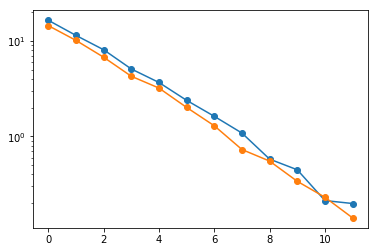

In [38]:
criterion = nn.MSELoss()
num_epochs = 1000;
batch_size = 1;

loss_train, loss_test = np.array([]), np.array([])
t0 = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data(['asdf'])
        batch_X = batch_data['x']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if np.isnan(running_loss):
            break
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0)>5:
            print('Epoch %d, i=%d/%d, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                              running_loss/nsamp, running_time, running_time/nsamp))
            t0=time.time()
            print(outputs[0,:])

    loss_train = np.append(loss_train,running_loss/nsamp)
    scheduler.step(running_loss/nsamp)
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data('asdf')
        batch_X = batch_data['x']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)
    loss_test = np.append(loss_test,running_loss_test/nsamp)

    plt.clf()
    plt.semilogy(loss_train,'o-')
    plt.semilogy(loss_test,'o-')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print('**** Epoch %d, loss_train=%3.8f, loss_test=%3.8f' % (epoch, loss_train[-1], loss_test[-1]))

#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss_train': loss_train,
#             'loss_test': loss_test,
#             }, fn_save)
#     print('Saved data: %s' % fn_save)

In [ ]:
plt.semilogy(loss_train,'o-')
plt.semilogy(loss_test,'o-');

In [ ]:
net.eval()
indices = test

yyhat = {'y':[], 'yhat':[]}
for ensid in np.arange(1000):
    # Input should be of size: (batch, channels, samples)
    batch_data = get_data(['asdf'])
    batch_X = batch_data['x']
    batch_y = batch_data['y']

    # Send training data to CUDA
    if device is not "cpu":
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

    outputs = net(batch_X)
    yyhat['yhat'].append(outputs.detach().cpu().numpy())
    yyhat['y'].append(batch_y)
yyhat['yhat'] = np.stack(yyhat['yhat']).squeeze()

In [ ]:
plt.plot(yyhat['yhat'].T,'.');